In [1]:
import os
import xarray as xr
import numpy as np
import cftime
import glob
import matplotlib.pyplot as plt

from osprey.utils.folders import folders
from osprey.utils.time import get_startleg, get_year, count_total_steps, get_forecast_year
from osprey.means.means import timemean
from osprey.means.eof import change_timeaxis
from osprey.actions.reader import elements
from osprey.utils import run_cdo
from osprey.actions.forecaster import forecaster_EOF_restart

In [2]:
expname = "FE01"
var = "tn"
ndim ="3D"
endleg = 11
yearspan = 5
yearleap = 10
startleg = get_startleg(endleg, yearspan)
startyear = get_year(startleg)
endyear = get_year(endleg)
window = endyear - startyear + 1
dirs = folders(expname)

In [3]:
data = forecaster_EOF_restart(expname, endleg, yearspan, yearleap)

Command: 'cdo -selname,tn /ec/res4/scratch/itas/martini/FE01/007/FE01*_restart.nc /ec/res4/scratch/itas/martini/FE01/007/aux.nc' 

/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'

Command: 'cdo -settaxis,1996-01-01,00:00:00,1year /ec/res4/scratch/itas/martini/FE01/007/aux.nc /ec/res4/scratch/itas/martini/FE01/007/tn_7.nc' 

/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'

File /ec/res4/scratch

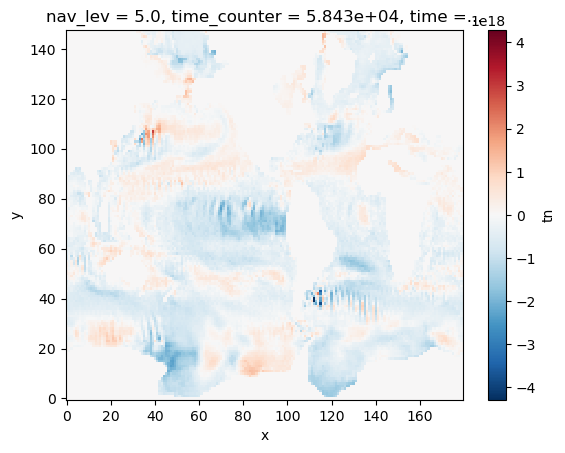

In [5]:
data['tn'].isel(time_counter=0,nav_lev=0).plot()

In [9]:
def _forecast_xarray(foreyear):
    """Get the xarray for the forecast time"""
    
    fdate = cftime.DatetimeGregorian(foreyear, 1, 1, 0, 0, 0, has_year_zero=False)
    xf = xr.DataArray(data = np.array([fdate]), dims = ['time'], coords = {'time': np.array([fdate])},
                      attrs = {'stardand_name': 'time', 'long_name': 'Time axis', 'bounds': 'time_counter_bnds', 'axis': 'T'})

    return xf

In [56]:
var='tn'
foreyear = get_forecast_year(endyear, yearleap)
xf = _forecast_xarray(foreyear)
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_pattern.nc")
pattern = xr.open_mfdataset(filename, use_cftime=True)
field = pattern.isel(time_counter=0)*0
for i in range(window):
    filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_series_0000{i}.nc")
    timeseries = xr.open_mfdataset(filename, use_cftime=True)
    p = timeseries.polyfit(dim='time_counter', deg=1, skipna = True)
    theta = xr.polyval(xf, p[f"{var}_polyfit_coefficients"])
    #theta = timeseries[var].isel(time_counter=-1,lat=0,lon=0,zaxis_Reduced=0)
    basis = pattern.isel(time_counter=i)
    field = field + theta*basis
#field = field.drop_vars({'time', 'lon', 'lat', 'zaxis_Reduced'})

In [57]:
field = field.drop_vars({'time', 'zaxis_Reduced', 'lat', 'lon'})
#field = field.drop_vars({'time', 'zaxis_Reduced', 'lat', 'lon'})
field = field.isel(time=0,zaxis_Reduced=0,lat=0,lon=0)
field

<xarray.Dataset> Size: 7MB
Dimensions:       (nav_lev: 31, y: 148, x: 180)
Coordinates:
    time_counter  float32 4B 1.0
  * nav_lev       (nav_lev) float32 124B 5.0 15.0 25.0 ... 4.75e+03 5.25e+03
Dimensions without coordinates: y, x
Data variables:
    tn            (nav_lev, y, x) float64 7MB dask.array<chunksize=(1, 1, 180), meta=np.ndarray>

In [3]:
run_cdo.merge_rebuilt(expname, startleg, endleg)

Command: 'cdo -selname,tn /ec/res4/scratch/itas/martini/FE00/007/FE00*_restart.nc /ec/res4/scratch/itas/martini/FE00/007/aux.nc' 

/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'

Command: 'cdo -settaxis,1996-01-01,00:00:00,1year /ec/res4/scratch/itas/martini/FE00/007/aux.nc /ec/res4/scratch/itas/martini/FE00/007/tn_7.nc' 

/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'

File /ec/res4/scratch

In [4]:
change_timeaxis(expname, var, startyear, endyear)

File /ec/res4/scratch/itas/martini/FE00/011/tn.nc successfully removed.


In [14]:
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_anomaly.nc")
xdata = xr.open_mfdataset(filename, use_cftime=True)
xdata

<xarray.Dataset> Size: 33MB
Dimensions:       (time_counter: 5, nav_lev: 31, y: 148, x: 180)
Coordinates:
  * time_counter  (time_counter) object 40B 1996-01-01 00:00:00 ... 2000-01-0...
  * nav_lev       (nav_lev) float32 124B 5.0 15.0 25.0 ... 4.75e+03 5.25e+03
Dimensions without coordinates: y, x
Data variables:
    tn            (time_counter, nav_lev, y, x) float64 33MB dask.array<chunksize=(1, 1, 1, 180), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    file_name:    /ec/res4/scratch/itas/martini/FE00/007/FE00_00035056_restar...
    TimeStamp:    25/06/2024 15:31:27 -0000
    history:      Thu Jul 04 08:37:57 2024: cdo sub /ec/res4/scratch/itas/mar...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

In [7]:
run_cdo.detrend(expname, var, endleg)
run_cdo.get_EOF(expname, var, endleg, window)

File /ec/res4/scratch/itas/martini/FE00/011/tn_anomaly.nc successfully removed.
Command: 'cdo sub /ec/res4/scratch/itas/martini/FE00/011/tn.nc -timmean /ec/res4/scratch/itas/martini/FE00/011/tn.nc /ec/res4/scratch/itas/martini/FE00/011/tn_anomaly.nc' 
cdo    sub: Filling up stream2 >(pipe1.4)< by copying the first timestep.

/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'

 Time window  5
File /ec/res4/scratch/itas/martini/FE00/011/tn_variance.nc successfully removed.
File /ec/res4/scratch/itas/martini/FE00/011/tn_pattern.nc successfully removed.
Command: 'cdo eof3d,5 /ec/res4/scratch/itas/martini/FE00/011/tn_anomaly.nc /ec/res4/scratch/itas/martini/FE00/011/tn_variance.nc /ec/res4/scratch

In [25]:
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_pattern.nc")
pattern = xr.open_mfdataset(filename, use_cftime=True)
field = pattern.isel(time_counter=0)*0
for i in range(window):
    filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_series_0000{i}.nc")
    timeseries = xr.open_mfdataset(filename, use_cftime=True)
    theta = timeseries[var].isel(time_counter=-1,lat=0,lon=0,zaxis_Reduced=0)
    basis = pattern.isel(time_counter=i)
    field = field + theta*basis
field = field.drop_vars({'time_counter', 'lon', 'lat', 'zaxis_Reduced'})

In [26]:
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}.nc")
xdata = xr.open_mfdataset(filename, use_cftime=True)
xdata = xdata.rename({'time_counter': 'time'})
ave = timemean(xdata, var)
total = field + ave
total

<xarray.Dataset> Size: 7MB
Dimensions:  (nav_lev: 31, y: 148, x: 180)
Coordinates:
  * nav_lev  (nav_lev) float32 124B 5.0 15.0 25.0 ... 4.25e+03 4.75e+03 5.25e+03
Dimensions without coordinates: y, x
Data variables:
    tn       (nav_lev, y, x) float64 7MB dask.array<chunksize=(1, 1, 180), meta=np.ndarray>

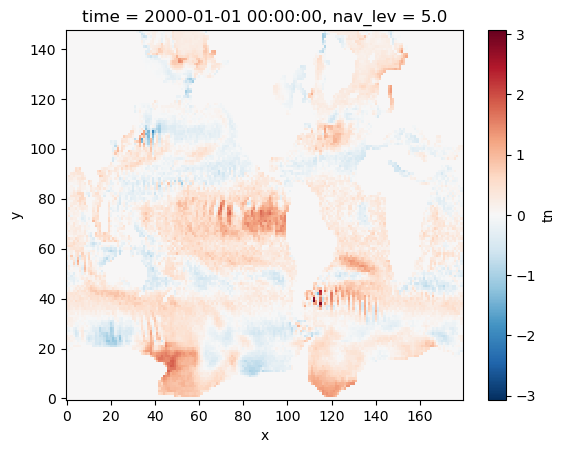

In [27]:
delta = xdata[var].isel(time=-1,nav_lev=0)-total[var].isel(nav_lev=0)
delta.plot()

In [28]:
df = elements(expname)

In [29]:
rpa = xdata[var].isel(time=-1).weighted(df['S']).mean(dim=['y', 'x'])
fpa = total[var].weighted(df['S']).mean(dim=['y', 'x'])

Text(0, 0.5, 'T')

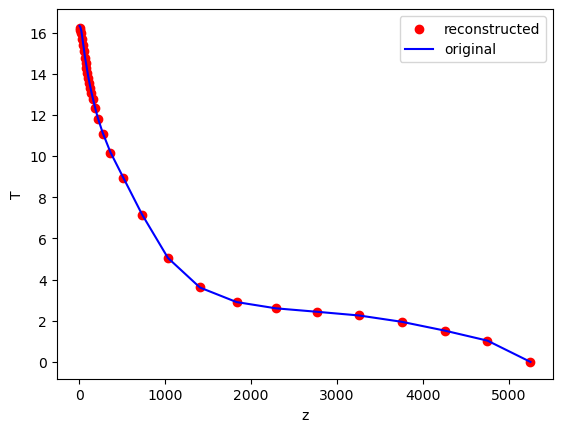

In [30]:
plt.scatter(fpa['nav_lev'].values,fpa.values, color='r', label='reconstructed')
plt.plot(rpa['nav_lev'].values,rpa.values, color='b', label='original')
plt.legend(loc="upper right")
plt.xlabel('z')
plt.ylabel('T')

Text(0, 0.5, 'T diff')

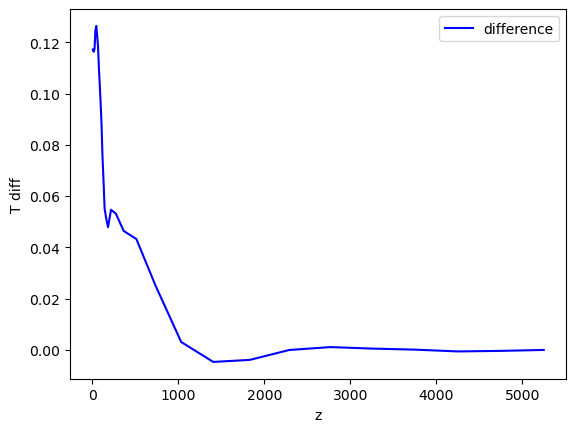

In [31]:
dpa = rpa-fpa 
plt.plot(rpa['nav_lev'].values, dpa.values, color='b', label='difference')
plt.legend(loc="upper right")
plt.xlabel('z')
plt.ylabel('T diff')